# Check hint effects on homework

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from pandas import DataFrame
from collections import defaultdict
import scipy.stats as stats
import numpy as np

## Load Data

In [2]:
hw_df = pd.read_pickle('../data/pkl_data/hw_data.pkl')
cols = hw_df.columns
problem_list = list(set([(c[0],c[1]) for c in cols if len(c)==3]))
hw_df.head(1)

,"(2, 10, 1)","(2, 10, 2)","(2, 10, 3)","(2, 10, 4)","(2, 11, 1)","(2, 11, 2)","(2, 12, 1)","(2, 12, 2)","(2, 12, 3)","(2, 12, 4)",...,"(8, 3, 1)","(8, 3, 2)","(8, 3, 3)","(8, 3, 4)","(8, 4, 1)","(8, 4, 2)","(8, 4, 3)","(8, 5, 1)","(8, 5, 2)","(8, 6, 1)"
ID,,,,,,,,,,,,,,,,,,,,,
247,"[[2016-10-04 01:07:43, 1/12, 1, null]]","[[2016-10-04 01:07:43, 5/6, 1, null]]","[[2016-10-04 01:07:43, 1/12, 1, null]]","[[2016-10-04 01:07:43, 1, 1, null]]","[[2016-10-04 01:08:00, 4, 1, null]]","[[2016-10-04 01:08:00, 1/13, 1, null]]","[[2016-10-04 01:11:02, 1024, 1, null], [2016-1...","[[2016-10-04 01:11:02, 1/1024, 1, null], [2016...","[[2016-10-04 01:11:02, 10, 1, null], [2016-10-...","[[2016-10-04 01:11:02, 1/512, 0, null], [2016-...",...,"[[2016-11-17 01:10:21, 400, 0, 400/64], [2016-...","[[2016-11-17 01:19:27, (e^(-400/81))*((400/81)...","[[2016-11-17 01:19:27, (e^(-400/81))*((400/81)...","[[2016-11-17 00:22:58, 1-e^(-150), Please fin...","[[2016-11-17 02:01:33, 1/10, 1, 80.0*1/800.0],...","[[2016-11-17 02:01:33, (e^-(1/10))*((1/10)^2/(...","[[2016-11-17 02:01:33, 1-e^(-(1/10)*(1/10)), 0...","[[2016-11-17 02:22:33, (1/6.5)e^(-6.5*9), 0, e...","[[2016-11-17 03:20:07, e^(-(10/5.5))*(((10/5.5...","[[2016-11-17 02:33:13, e^(-2.1), 0, ((1/2) * e..."


In [4]:
hint_feature_df = pd.read_pickle("../data/pkl_data/hint_feature_df.pkl")
hint_feature_df.head(3)

,"(7, 6, hint_count)","(4, 4, hint_count)","(8, 3, hint_count)","(5, 5, hint_count)","(7, 2, hint_count)","(4, 1, hint_count)","(8, 4, hint_count)","(7, 5, hint_count)","(4, 5, hint_count)","(5, 4, hint_count)",...,"(8, 2, time_spent)","(6, 6, time_spent)","(3, 1, time_spent)","(7, 3, time_spent)","(2, 12, time_spent)","(6, 5, time_spent)","(6, 4, time_spent)","(3, 5, time_spent)","(6, 3, time_spent)","(5, 1, time_spent)"
ID,,,,,,,,,,,,,,,,,,,,,
247,0,0,1,0,0,0,0,0,0,0,...,0,1160,0,3684,0,1044,0,0,6345,3444
336,0,0,0,3,0,0,0,0,0,0,...,0,960,268,0,0,0,177,0,8185,992
109,0,4,0,0,0,0,0,0,4,0,...,0,292,0,0,0,0,363,35,0,1867


## Compare dataframes

In [320]:
### Functions
def find_ave(df, feature, problem_list):
    """Find average tries for
    1. control students
    2. control students who would have got a hint
    """
    ### Average tries for students with no hint assigned
    control_ave = defaultdict(float)
    
    ### Average tries for students with no hint assigned but would have got a hint
    control_hint_ave = defaultdict(float)
    
    for pro in sorted(problem_list):
        if int(pro[0]) < 4: # skip assignment 1, 2, and 3
            continue
        hint_count_name = (pro[0], pro[1], 'hint_count')
        tries_name = (pro[0], pro[1], 'tries')
        assign_name = (pro[0], 'assign')
        pro_key = (pro[0], pro[1])
        feature_name = (pro[0], pro[1], feature)

        #all control students
        control_df = df[(df[assign_name] == '0') & (df[tries_name] > 0)]
        if len(control_df) != 0:
            control_ave[pro_key] = control_df[feature_name].mean()
            #print pro, 'all control size', len(control_df)

        #control students who would have got a hint
        control_hint_df = df[(df[assign_name] == '0') & (df[hint_count_name] > 0) & (df[tries_name] > 0)]
        if len(control_hint_df) != 0:
            control_hint_ave[pro_key] = control_hint_df[feature_name].mean()
            
    return control_ave, control_hint_ave


def after_first_problems(HW_df, df):
    """ Find the problems after the first hint problem for each student in each assignment """
    studentID_list = df.index.tolist()
    after_first_pros = {}
    for ind, row in HW_df.iterrows():
        if not ind in studentID_list:
            continue
        assign_after_first = defaultdict(str)
        pro_finish_time = {}
        col_count = 0
        hint_times = {}
        hint_pros = {}
        no_hint_pros = []
        row = row.fillna(-111)
        cols = row.index.tolist()
        for r in row:
            title = cols[col_count]
            if int(title[0]) < 4 or r == -111:
                col_count += 1
                continue
            if type(r) is int:
                print r
            pro_finish_time[title] = pd.to_datetime(r[-1][0])
            pro_hint_time = [pd.to_datetime(t[0]) for t in r if t[-1] == "Hint"]
            if pro_hint_time:
                first_pro_hint_time = min(pro_hint_time)
                if title[0] not in hint_times.keys():
                    hint_times[title[0]] = first_pro_hint_time
                    hint_pros[title[0]] = title[1]
                elif hint_times[title[0]] > first_pro_hint_time:
                    hint_times[title[0]] = first_pro_hint_time
                    hint_pros[title[0]] = title[1]
            else:
                no_hint_pros.append(title)
            col_count += 1
        
        if hint_times:
            for c in cols:
                if int(c[0]) < 4:
                    continue
                if c[0] in hint_times.keys()\
                and c in pro_finish_time\
                and pro_finish_time[c] > hint_times[c[0]]\
                and c in no_hint_pros\
                and c[1] != hint_pros[c[0]]:
                    if not assign_after_first[c[0]]:
                        assign_after_first[c[0]] = [c[1]]
                    elif c[1] not in assign_after_first[c[0]]:
                        assign_after_first[c[0]].append(c[1])
        after_first_pros[ind] = assign_after_first
    return after_first_pros


def feature_per_problem(df, feature, problem_list, after_first_pros):
    """
    Find sum of attempts/times for problems with hints and without hints for case students
    The input feature would be either attempts or times
    """
    ### Find the list of attempts/times for problems for control students
    control_feature = defaultdict(list)  #{pro_id:[feature list]}

    ### Find the list of attempts/times for problems for case students
    case_feature = defaultdict(list)

    for ind, row in df.iterrows():
        for pro in sorted(problem_list):
            if int(pro[0]) < 4: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (pro[0], pro[1], 'hint_count')
            assign_key = (pro[0],'assign')
            feature_key = (pro[0],pro[1],feature)
            pro_key = (pro[0], pro[1])
                
            if row[assign_key] == '0' and row[h_count_key] > 0:
                if row[feature_key]:
                    control_feature[pro].append(row[feature_key])
            else:
                if after_first_pros[ind][pro[0]]: #has at least one hint in assignment pro[0]
                    if pro[1] in after_first_pros[ind][pro[0]] and row[h_count_key] == 0 and row[feature_key]:
                        case_feature[pro].append(row[feature_key])

    return control_feature, case_feature


def feature_per_assignment(df, feature, problem_list):
    """
    Find sum of attempts/times for problems with hints and without hints for case students
    The input feature would be either attempts or times
    """
    ### Find the list of attempts/times for problems for control students
    control_feature = defaultdict(list)  #{pro_id:[feature list]}

    ### Find the list of attempts/times for problems for case students
    case_feature = defaultdict(list)

    for ind, row in df.iterrows():
        assignment_control = defaultdict(int)
        assignment_case = defaultdict(int)
        for pro in sorted(problem_list):
            if int(pro[0]) < 4: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (pro[0], pro[1], 'hint_count')
            assign_key = (pro[0],'assign')
            feature_key = (pro[0],pro[1],feature)
            pro_key = (pro[0], pro[1])
            
            if row[feature_key] and row[h_count_key] > 0:
                if row[assign_key] == '0':
                    assignment_control[pro[0]] += row[feature_key]
                elif row[assign_key] == '1':
                    assignment_case[pro[0]] += row[feature_key]
        for assignment in ['4', '5', '6', '7', '8']:
            if assignment_control[assignment]:
                control_feature[assignment].append(assignment_control[assignment])
            if assignment_case[assignment]:
                case_feature[assignment].append(assignment_case[assignment])

    return control_feature, case_feature


def case_per_assignment(df, control_ave, feature, problem_list, after_first_pros):
    """
    Find sum of attempts/times for problems with hints and without hints for case students
    The input feature would be either attempts or times
    """
    ### Find the list of attempts/times for problems for control students
    control_feature = defaultdict(list)  #{pro_id:[feature list]}

    ### Find the list of attempts/times for problems for case students
    case_feature = defaultdict(list)

    for ind, row in df.iterrows():
        assignment_control = defaultdict(int)
        assignment_case = defaultdict(int)
        for pro in sorted(problem_list):
            if int(pro[0]) < 4: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (pro[0], pro[1], 'hint_count')
            assign_key = (pro[0],'assign')
            feature_key = (pro[0],pro[1],feature)
            pro_key = (pro[0], pro[1])
                
            if row[assign_key] == '1':
                if after_first_pros[ind][pro[0]]: #has at least one hint in assignment pro[0]
                    if pro[1] in after_first_pros[ind][pro[0]] and row[h_count_key] == 0 and row[feature_key] and control_ave[pro_key]:
                        assignment_case[pro[0]] += row[feature_key]
                        assignment_control[pro[0]] += control_ave[pro_key]
        for assignment in ['4', '5', '6', '7', '8']:
            if assignment_case[assignment]:
                case_feature[assignment].append(assignment_case[assignment])
                control_feature[assignment].append(assignment_control[assignment])

    return control_feature, case_feature


def stats_between(control_feature, case_feature, problem_list):
    """Statistic results
    Calculate average of (control - case) and perform t-test"""
    control_mean = []
    case_mean = []
    pros = []
    p_vals = []
    diff_list = []
    all_control = []
    all_case = []
    for pro in sorted(problem_list):#['4', '5', '6', '7']:
        control_pro = control_feature[pro]
        case_pro = case_feature[pro]
        diff = np.mean(control_pro)-np.mean(case_pro)
        if control_pro and case_pro and diff:
            all_control += control_pro
            all_case += case_pro
            stat_values = stats.ttest_ind_from_stats(np.mean(control_pro), np.std(control_pro), len(control_pro), np.mean(case_pro), np.std(case_pro), len(case_pro))
            #stat_values = stats.ttest_ind(case_pro, control_pro)
            #stat_values = stats.ttest_1samp(case_pro, sum(control_pro)/(1. * len(control_pro)))
            pros.append(pro)
            control_mean.append(np.mean(control_pro))
            case_mean.append(np.mean(case_pro))
            p_vals.append(stat_values[1])
            diff_list.append(diff)
            #print "{0} & {1:.3f} & {2:.3f} & {3:.3f} & {4:.3f} ".format(len(case_pro), np.mean(case_pro)/60., np.std(case_pro)/60., stat_values[1], diff/60.)
            
    all_stat = stats.ttest_1samp(all_case, sum(all_control)/(1. * len(all_control)))
    #print "all: {0} & {1} & {2} & {3} & {4} ".format(len(all_case), np.mean(all_case), np.std(all_case), all_stat[1], np.mean(all_control)-np.mean(all_case))
    return pros, control_mean, case_mean, p_vals, diff_list


def comparison(hint_feature_df, HW_df, feature, problem_list):
    """Compare data between two dataframe"""
    
    ### Get baseline averages
    #control_ave, control_hint_ave = find_ave(hint_feature_df, feature, problem_list)
    after_hint_pros = after_first_problems(HW_df, hint_feature_df)
    #control_feature, case_feature = case_per_assignment(hint_feature_df, control_hint_ave, feature, problem_list, after_hint_pros)
    
    control_feature, case_feature = feature_per_problem(hint_feature_df, feature, problem_list, after_hint_pros)
    
    #control_feature, case_feature = feature_per_assignment(hint_feature_df, feature, problem_list)
    return stats_between(control_feature, case_feature, problem_list)

In [321]:
try_pros, try_control, try_case, try_p_vals, try_diff = comparison(hints_df_all, hw_df, 'tries', problem_list)

In [322]:
time_pros, time_control, time_case, time_p_vals, time_diff = comparison(hints_df_all, hw_df, 'time_spent', problem_list)

In [ ]:

### Students with no hints in some of the problem are students who didn't click show hint button.
### There are students who didn't click any show hint button in a whole week.

### Could study whether students tend to not click show-hint for same type of problems and finish them faster

## Feature t-test

In [57]:
### Functions
def fea_p_val_sum(fea_name, df, problem_list):
    p_vals = defaultdict(float)
    h = defaultdict(float)
    nh = defaultdict(float)
    h_pro = defaultdict(int)
    nh_pro = defaultdict(int)
    for p in sorted(problem_list):
        if int(p[0]) < 4:
            continue
        pn = (p[0], p[1], 'hint_count')
        h_df = df[(df[pn] > 0) & (df[(p[0],'assign')] == '1')]
        nh_df = df[(df[pn] > 0) & (df[(p[0],'assign')] == '0')]
        if len(h_df) == 0 or len(nh_df) == 0:
            continue

        #print 'hint ', p, h_df[(p[0],p[1],fea_name)].mean()
        #print 'no hint ', p, nh_df[(p[0],p[1],fea_name)].mean()
        for ind,row in h_df.iterrows():
            h[ind] += row[(p[0],p[1],fea_name)]
            h_pro[ind] += 1
        for ind,row in nh_df.iterrows():
            nh[ind] += row[(p[0],p[1],fea_name)]
            nh_pro[ind] += 1
            
    nam_diff1 = [s for s in h.keys() if s not in nh.keys()]
    nam_diff2 = [s for s in nh.keys() if s not in h.keys()]
    for n in nam_diff1:
        del h[n]
    for n in nam_diff2:
        del nh[n]
    
    for k in h:
        h[k] = h[k]/h_pro[k]
    for k in nh:
        nh[k] = nh[k]/nh_pro[k]
    
    h_list = np.array(h.values())
    nh_list = np.array(nh.values())
    hint_mean = h_list.mean()
    nh_mean = nh_list.mean()
    hint_std = h_list.std()
    nh_std = nh_list.std()
    h_len = len(h_list)
    nh_len = len(nh_list)
    diff = h_list - nh_list
    print diff.mean()
    
    #t_val, p_val = stats.ttest_ind_from_stats(hint_mean, hint_std, h, nh_mean, nh_std, no_h)
    t_val, p_val = stats.ttest_rel(h.values(), nh.values())
    return hint_mean, nh_mean, p_val


def stats_between_dfs(h_df, noh_df, final_col, print_enabled=True):
    h = len(h_df)
    no_h = len(noh_df)
    if h == 0 or no_h == 0:
        print "ERROR: Empty dataframe passed in..."
        return
    hint_mean = h_df[final_col].mean()
    nh_mean = noh_df[final_col].mean()
    hint_std = h_df[final_col].std()
    nh_std = noh_df[final_col].std()
    
    if(print_enabled):
        print h
        print no_h
        print 'with_hint: ', h/(h+no_h*1.)
        print 'with_no_hint: ', no_h/(h+no_h*1.)

        print '\n mean'
        print hint_mean
        print nh_mean

        print '\n std'
        print hint_std
        print nh_std

        print '\n ttest'
    return stats.ttest_ind_from_stats(hint_mean, hint_std, h, nh_mean, nh_std, no_h)


def fea_p_val(fea_name, df, problem_list):
    p_vals = []
    pro_list = []
    h = []
    nh = []
    pros_stat = []
    for p in sorted(problem_list):
        if int(p[0]) < 4:
            continue
        pn = (p[0], p[1], 'hint_count')
        h_df = df[(df[pn] > 0) & (df[(p[0],'assign')] == '1')]
        nh_df = df[(df[pn] > 0) & (df[(p[0],'assign')] == '0')]
        if len(h_df) == 0 or len(nh_df) == 0:
            continue
        pros_stat.append(p)
        st = stats_between_dfs(h_df, nh_df, (p[0],p[1],fea_name), False)
        if st and st[1] == st[1]:
            p_vals.append(st[1])
            pro_list.append(p)
            h.append(h_df[p[0],p[1],fea_name].mean())
            nh.append(nh_df[p[0],p[1],fea_name].mean())
    return p_vals, pro_list, h, nh

In [58]:
fea_p_val_sum('tries', hints_df_all, problem_list)

-2.42107244607


(24.051902726902725, 26.472975172975179, 0.28806641029241092)

In [59]:
fea_p_val_sum('time_spent', hints_df_all, problem_list)

-432.195716321


(2063.7179385429386, 2495.9136548636548, 0.051700585743275733)

In [60]:
p_vals, pros_time, h_time, nh_time = fea_p_val('time_spent', hints_df_all, problem_list)

## Plots

In [330]:
### Functions and params for ploting graphs
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

def plot_hints(x, y_case, y_control, label):
    plt.plot(x, y_case, '-o', label='case group')
    plt.plot(x, y_control, '-^', label='control group')
    plt.legend(loc=4)
    for i,l in enumerate(label):
        if l > 0.01:
            plt.annotate(
                "%.3f"%l,
                xy=(x[i], y_control[i]), xytext=(10, 15),
                textcoords='offset points', ha='right', va='bottom', size=10,
            	arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', relpos=(0.1,0.5)))    
    
def fig_setting():
    plt.figure(figsize=(10,5))
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    return plt

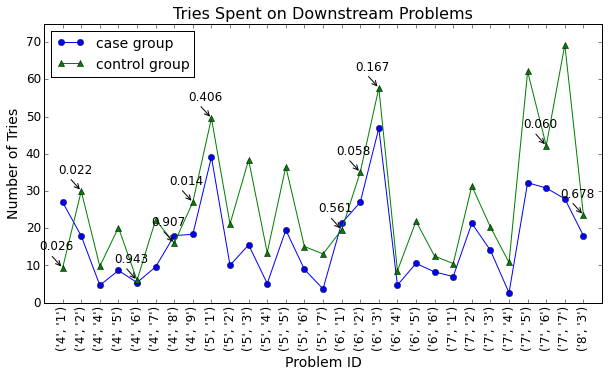

In [328]:
plt = fig_setting()
plot_hints(range(0,len(try_pros)), try_case, try_control, try_p_vals)
plt.xticks(range(0,len(try_pros)), try_pros, rotation='vertical')
plt.title('Tries Spent on Downstream Problems')
plt.xlabel('Problem ID')
plt.ylabel('Number of Tries')
plt.xlim((-1, 29))
plt.ylim(ymax=75)
plt.legend(loc=2)
plt.savefig('../graphs/problem_tries_downstream.png', bbox_inches='tight', pad_inches=0.2)

In [255]:
np.histogram(np.subtract(try_control,try_case), bins = 5)

(array([ 1,  8, 17,  1,  2]),
 array([-17.66666667,  -5.85030303,   5.96606061,  17.78242424,
         29.59878788,  41.41515152]))

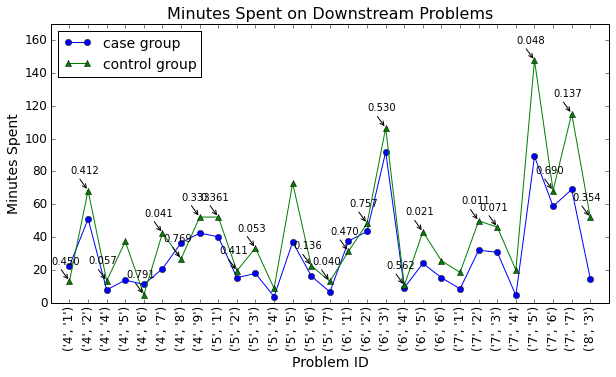

In [332]:
plt = fig_setting()
plot_hints(range(0,len(time_pros)), np.array(time_case)/60., np.array(time_control)/60., time_p_vals)
plt.xticks(range(0,len(time_pros)), time_pros, rotation='vertical')
plt.title('Minutes Spent on Downstream Problems')
plt.xlabel('Problem ID')
plt.ylabel('Minutes Spent')
plt.xlim((-1, 29))
plt.ylim(ymax=170)
plt.legend(loc=2)
plt.savefig('../graphs/problem_time_downstream.png', bbox_inches='tight', pad_inches=0.2)

### Feature Diff

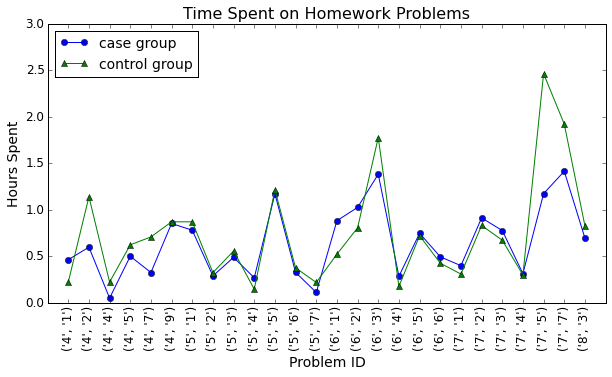

In [21]:
plt = fig_setting()
plot_hints(range(0,len(pros_time)), np.array(h_time)/3600., np.array(nh_time)/3600.)
plt.xticks(range(0,len(pros_time)), pros_time, rotation='vertical')
plt.title('Time Spent on Homework Problems')
plt.xlabel('Problem ID')
plt.ylabel('Hours Spent')
plt.xlim((-1, 26))
plt.ylim(ymax=3)
plt.legend(loc=2)
#plt.savefig('../graphs/new_times_analysis.png', bbox_inches='tight', pad_inches=0.2)

In [18]:
### Output table for latex
p_vals_tries, pros_tries, h_tries, nh_tries = fea_p_val('tries', hints_df_all, problem_list)

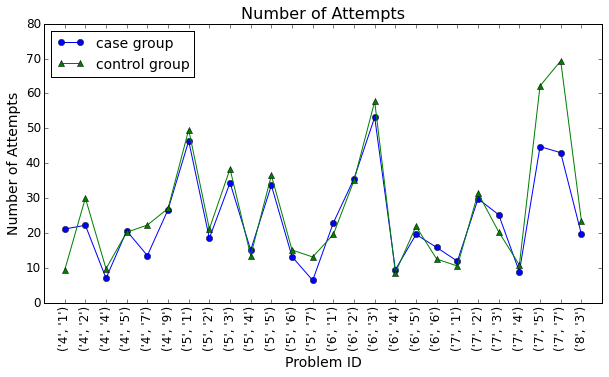

In [22]:
plt = fig_setting()
plot_hints(range(0,len(pros_tries)), h_tries, nh_tries)
plt.xticks(range(0,len(pros_tries)), pros_tries, rotation='vertical')
plt.title('Number of Attempts', fontsize=BIGGER_SIZE)
plt.ylim(ymax=80)
plt.xlim((-1, 26))
plt.xlabel('Problem ID')
plt.ylabel('Number of Attempts')
plt.legend(loc=2)
#plt.savefig('../graphs/new_tries_analysis.png', bbox_inches='tight', pad_inches=0.2)